# HPC Coursework 3: Sparse Matrices

This assignment will involve creating custom classes that inherit from the scipy LinearOperator classes that are designed to store data in a more efficient format. They will include operator override methods such as __add__ and _matvec and will leverage numba JIT compilation with static methods to accelerate computations. Part 1 will revolve around a class I made that mimics the scipy csr_matrix object and part 2 will include a class made to store a custom sparse matrix.

In [1]:
from scipy.sparse import coo_matrix,random,csr_matrix,csr_array,diags
from scipy.sparse.linalg import LinearOperator
import numpy as np
from numba import jit,njit,prange
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.sparse.linalg import gmres, cg, eigs

Below my custom CSRMatrix class can be seen which inherits from the LinearOperator class. As well as adding the __add__ and _matvec methods I have added __len__, __str__, __eq__ and __getitem__ to give my class matrix addition, vector multiplication, print, equivalence and indexing functionality.

In [2]:
class CSRMatrix(LinearOperator):
    """
    This class stores data in the CSR Matrix data format.
    Initialisation:
        Inputs:
            Coo_matrix - tuple | scipy.sparse.coo_matrix(): data, indices and indptr of CSR Matrix with optional argument shape required 
            | Matrix in COO Format
            dtype - dtype: data type of matrix. (optional)
            shape - tuple: shape of matrix. (optional)
            modes - dict: dictionary containing two parameters determing whether the matrix addition produces a Scipy result or a CSRMatrix object result
            and if numba is used to accelerate operations.

    """
    def __init__(self, Coo_matrix,dtype = np.float64,shape = None,modes = {"add scipy":True,"use numba":True}):
        self.modes = modes
        if type(Coo_matrix) == tuple: # allow for direct shape, data, indices and indptr inputs 
            if type(shape) == type(None):
                raise ValueError("Shape Not Defined")
            self.shape = shape
            self.dtype = dtype
            self.data = Coo_matrix[0]
            self.indices = Coo_matrix[1]
            self.indptr = Coo_matrix[2]
        else:    
            if type(Coo_matrix) != coo_matrix:
                raise TypeError(f"Expected {coo_matrix} found {type(Coo_matrix)}.")
            self.shape = Coo_matrix.shape
            self.dtype = Coo_matrix.dtype
            sorted_order = np.lexsort((Coo_matrix.col,Coo_matrix.row))   # essential to sort rows and columns in ascending order. 
            self.data = Coo_matrix.data[sorted_order].astype(self.dtype) # rows used as primary index and columns used as secondary index.
            self.indices = Coo_matrix.col[sorted_order].astype(np.int32) 
            if modes["use numba"]:
                self.indptr = self.numba_indptr_gen(Coo_matrix.row[sorted_order],self.shape[0])
            else:
                self.indptr = self.indptr_gen(Coo_matrix.row[sorted_order])

    def indptr_gen(self, sorted_rows):
        """
        Generates indptr attribute if numba processing is not available.
        Inputs: 
            sorted_rows - numpy array : Array of all rows sorted in ascending order.
        Outputs:
            indptr - int : pointers that distinguish between rows in the data and indices attributes.
        """
        n_rows = self.shape[0]
        indptr = np.zeros(n_rows + 1, dtype=np.int32)
        for row_index in sorted_rows:
            indptr[row_index + 1] += 1
        np.cumsum(indptr, out=indptr)
        return indptr
    def __eq__(self,other):
        """
        This method checks for equivalency of two CSRMatrix objects.
        Input:
            other - CSRMatrix object: other CSR matrix to be addded.
        Output:
            bool - Depends on equivalency.
        """
        return self.shape == other.shape and np.array_equal(self.data, other.data) and np.array_equal(self.indices, other.indices) \
            and np.array_equal(self.indptr, other.indptr)
    def __len__(self):
        raise TypeError("sparse array length is ambiguous; use shape[0]")
    
    @staticmethod
    @njit()
    def add_wrapper(shape,dtype,class_data,class_indices,class_indptr,other_data,other_indices,other_indptr):
        """
        JIT compiled matrix addition wrapper.
        """
        
        # Estimate the size of the arrays needed
        # Estimate the size of the arrays needed
        max_size = len(class_data) + len(other_data)
        data = np.empty(max_size, dtype=dtype)
        indices = np.empty(max_size, dtype=np.int32)
        indptr = np.zeros(len(class_indptr), dtype=np.int32)
        idx=0    # Current index in the data and indices arrays
        for i in range(shape[0]):
            start1, end1 = class_indptr[i], class_indptr[i + 1]
            start2, end2 = other_indptr[i], other_indptr[i + 1]
            idx1, idx2 = start1, start2

            while idx1 < end1 and idx2 < end2:
                col1 = class_indices[idx1]
                col2 = other_indices[idx2]

                if col1 == col2:
                    data[idx] = class_data[idx1] + other_data[idx2]
                    indices[idx] = col1
                    idx1 += 1
                    idx2 += 1
                elif col1 < col2:
                    data[idx] = class_data[idx1]
                    indices[idx] = col1
                    idx1 += 1
                else:
                    data[idx] = other_data[idx2]
                    indices[idx] = col2
                    idx2 += 1
                idx += 1
            
            while idx1 < end1:
                data[idx] = class_data[idx1]
                indices[idx] = class_indices[idx1]
                idx1+=1
                idx+=1
            while idx2 < end2:
                data[idx] = other_data[idx2]
                indices[idx] = other_indices[idx2]
                idx2 += 1
                idx += 1
            indptr[i + 1] = idx
        # Trimming arrays to actual size
        data = data[:idx]
        indices = indices[:idx]
        return data, indices, indptr
    
    def __add__(self, other):
        """
        Add the CSR matrix other to this matrix.
        Input:
            other - CSRMatrix Object: CSR matrix to be added.
        Ouputs:
            scipy csr_array | CSRMatrix: resultant csr matrix.

        """
        if type(other)==str:
            raise TypeError("String data type unsuitable for matrix addition.")
        condition = True
        try:
            int(other)
        except:
            condition = False
        if condition:
            raise NotImplementedError("Adding a non zero scalar to a sparse matrix is not supported.")
        if type(other) == list:
            other = np.array(other)
        if self.shape != other.shape and condition:
            raise ValueError(f"Operands cannot be broadcast together with shapes {self.shape} & {other.shape}.")

        if self.modes["use numba"]:
            data, indices, indptr = self.add_wrapper(self.shape,self.dtype,self.data,self.indices,self.indptr,other.data,other.indices,other.indptr)
        else:
            # Estimate the size of the arrays needed
            max_size = len(self.data) + len(other.data)
            data = np.empty(max_size, dtype=self.dtype)
            indices = np.empty(max_size, dtype=np.int32)
            indptr = np.zeros(len(self.indptr), dtype=np.int32)
            idx=0    # Current index in the data and indices arrays
            for i in range(self.shape[0]):
                start1, end1 = self.indptr[i], self.indptr[i + 1]
                start2, end2 = other.indptr[i], other.indptr[i + 1]
                idx1, idx2 = start1, start2

                while idx1 < end1 and idx2 < end2:
                    col1 = self.indices[idx1]
                    col2 = other.indices[idx2]

                    if col1 == col2:
                        data[idx] = self.data[idx1] + other.data[idx2]
                        indices[idx] = col1
                        idx1 += 1
                        idx2 += 1
                    elif col1 < col2:
                        data[idx] = self.data[idx1]
                        indices[idx] = col1
                        idx1 += 1
                    else:
                        data[idx] = other.data[idx2]
                        indices[idx] = col2
                        idx2 += 1
                    idx += 1
            
                while idx1 < end1:
                    data[idx] = self.data[idx1]
                    indices[idx] = self.indices[idx1]
                    idx1+=1
                    idx+=1
                while idx2 < end2:
                    data[idx] = other.data[idx2]
                    indices[idx] = other.indices[idx2]
                    idx2 += 1
                    idx += 1
                indptr[i + 1] = idx
            # Trimming arrays to actual size
            data = data[:idx]
            indices = indices[:idx]
        #print(data,indices,indptr)
        if self.modes["add scipy"]:    
            return csr_array((data, indices, indptr), shape=self.shape, dtype=self.dtype)  ##### note: used scipy csr for validation. 
        else:                                                                                 # Function can alternatively take its own class
            return CSRMatrix((data,indices, indptr), shape=self.shape,dtype = self.dtype)  ##### __eq__ method added to validate                                                  
    
    def _matvec(self, vector):
        """
        Compute a matrix-vector product.
        """
        if vector.shape[0] != self.shape[1]:
            raise ValueError("Could not compute matrix vector product for shapes",self.shape,vector.shape)
        if self.modes["use numba"]:
            return self._matvec_wrapper(self.data,self.indices,self.indptr,self.shape,vector)
        else:
            end_vec = np.zeros(self.shape[0],dtype = vector.dtype)
            for i in range(self.shape[0]):
                start, end = self.indptr[i], self.indptr[i+1]
                for j in range(start,end):
                    end_vec[i] += self.data[j] * vector[self.indices[j]]
            return end_vec

    @staticmethod
    @njit(parallel=True)
    def _matvec_wrapper(data,indices,indptr,shape,vector):
        """
        _matvec method wrapper that is a static method so that it can be just in time compiled using numba.
        Function adapted from lecture notes found at: https://tbetcke.github.io/hpc_lecture_notes/sparse_data_structures.html
        """
        end_vec = np.zeros(shape[0],dtype=vector.dtype)
        for i in prange(shape[0]):
            start, end = indptr[i], indptr[i+1]
            for j in range(start,end):
                end_vec[i] += data[j] * vector[indices[j]]
        return end_vec 
    
    @staticmethod
    @njit()  ### static method used to allow numba acceleration
    def numba_indptr_gen(rows,n_rows):
        """
        Generates indptr attribute but used JIT compilation.
        """
        indptr = np.zeros(n_rows + 1, dtype=np.int32)
        for i in range(len(rows) - 1):
            if rows[i + 1] != rows[i]:
                # Fill gaps in indptr if any
                gap = rows[i + 1] - rows[i]
                indptr[rows[i] + 1: rows[i] + 1 + gap] = i + 1
        indptr[rows[-1] + 1] = len(rows)
        return indptr
    
    @staticmethod
    @njit(parallel = True)
    def rowfind(indptr,i):
        for j in prange(len(indptr)-1):
            if indptr[j] < i and indptr[j+1] > i:
                row = j
        return row
    
    def __str__(self):
        """
        This method overrides the python print function.
        """
        string = ''
        for i in range(len(self.data)):
            if self.modes['use numba']:
                row = self.rowfind(self.indptr,i)
            else:
                for j in range(len(self.indptr)):
                    if self.indptr[j] < i and self.indptr[j+1] > i:
                        row = j
            string += f'({row},{self.indices[i]}) : {self.data[i]} \n'
        return string
    
    @staticmethod
    @njit(parallel=True)
    def dense_helper(shape,data,indices,indptr):
        """
        Parallelised helper method to convert the CSRMatrix to a dense matrix.
        """
        dense_mat = np.zeros(shape)
        for i in prange(shape[0]):
            start, end = indptr[i], indptr[i+1]
            data_slice = data[start:end]
            col_slice = indices[start:end]
            for j in range(len(data_slice)):
                dense_mat[i,col_slice[j]] = data_slice[j]
        return dense_mat

    def __getitem__(self,key):
        """
        Method for indexing. key has to be a 2 dimensional tuple. Row slicing does not work. 
        """
        start, end = self.indptr[key[0]],self.indptr[key[0] + 1]
        if start == end:
            return self.dtype.type(0)
        else:
            Dict = dict(zip(self.indices[start:end],self.data[start:end]))
            try:
                return Dict[key[1]]
            except:
                return self.dtype.type(0)

    def todense(self):
        if self.modes['use numba']:
            return self.dense_helper(self.shape,self.data,self.indices,self.indptr)
        else:
            dense_mat = np.zeros(self.shape)
            for i in range(self.shape[0]):
                start,end = self.indptr[i], self.indptr[i+1]
                data_slice = self.data[start:end]
                col_slice = self.indices[start:end]
                for j in range(len(data_slice)):
                    dense_mat[i,col_slice[j]] = data_slice[j]
            return dense_mat

Below the additional functionality such as allowing for the equivalence operator to be used in the test_addition() function and the usage of the print function and indexing compatibility is demonstrated below.

Although it takes a significant time to run, a large portion of the run time is a result of sorting the matrix so that the rows are in ascending order with the ascending order of the columns in place as a secondary index. Therefore the numba implementation is extremely fast even for a 10,000 by 10,000 matrix given the numba implementation. As can be seen below when using the non numba implementation the run time is 1min 7s. This shows that including numba static method helper functions speeds up the coo to csr matrix format conversions.

In [3]:
N = 10000
test_matrix = random(N,N,density = 0.3)

In [4]:
%%time
custom_csr = CSRMatrix(test_matrix)

CPU times: user 9.28 s, sys: 131 ms, total: 9.41 s
Wall time: 9.55 s


In [5]:
%%time
CSRMatrix(test_matrix,modes = {"add scipy":True,"use numba":False})

CPU times: user 1min 5s, sys: 165 ms, total: 1min 5s
Wall time: 1min 5s


<10000x10000 CSRMatrix with dtype=float64>

In [6]:
%%time
ind = np.lexsort((test_matrix.col,test_matrix.row))

CPU times: user 8.36 s, sys: 20.3 ms, total: 8.38 s
Wall time: 8.38 s


The accuracy of the coo to csr conversion of my CSRMatrix object is shown below by the attributes of the scipy and my implementation being identical.

In [7]:
scipy_csr =test_matrix.tocsr() 
print(np.sum(abs(custom_csr.indptr - scipy_csr.indptr))) ##test if the custom and scipy sparse matrix are the same.
print(np.sum(abs(custom_csr.data - scipy_csr.data)))
print(np.sum(abs(custom_csr.indices - scipy_csr.indices)))

0
0.0
0


In [8]:
small = random(20,40,density = 0.2) ##smaller matrices for demonstration purposes. Irregular shape included
custom_small = CSRMatrix(small)
csr_small = small.tocsr()
print(csr_small.data - custom_small.data)
print(csr_small.indices - custom_small.indices)
print(csr_small.indptr - custom_small.indptr) ### as all the differences are 0 this means 
                                              ### that the CSRMatrix function is correct for non square matrices as well

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [9]:
print("Below we find the print functionality for CSRMatrix:\n",custom_small,
      '\n It can also be seen that the indexing functionality is present:\n',custom_small[0,12])

Below we find the print functionality for CSRMatrix:
 

/home/gsaba/.local/lib/python3.10/site-packages/numba/parfors/parfor_lowering.py:1144: NumbaParallelSafetyWarning: Variable row used in parallel loop may be written to simultaneously by multiple workers and may result in non-deterministic or unintended results.

File "../../../tmp/ipykernel_80346/3838411461.py", line 226:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaParallelSafetyWarning(msg, loc))
/home/gsaba/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


(0,11) : 0.22643384462361837 
(0,15) : 0.642408918385894 
(0,16) : 0.9188028628497599 
(0,19) : 0.3224172229364183 
(0,24) : 0.5214115695430513 
(0,25) : 0.10091274681582518 
(0,26) : 0.025263836390181815 
(0,28) : 0.5093061919803026 
(0,32) : 0.5463614413018038 
(0,39) : 0.8318110792617641 
(0,1) : 0.34711794297070375 
(1,6) : 0.6944489521768455 
(1,13) : 0.5469340623136415 
(1,23) : 0.47200075656564655 
(1,26) : 0.3032598913844162 
(1,30) : 0.5956749815085062 
(1,34) : 0.021338847608935674 
(0,10) : 0.8758697177419242 
(2,16) : 0.44761543009529503 
(2,26) : 0.4276064237203583 
(2,28) : 0.8792919704809267 
(2,33) : 0.45737349383981973 
(0,2) : 0.3769029911110219 
(3,6) : 0.2659036103767618 
(3,10) : 0.21605042328434865 
(3,15) : 0.233701521692532 
(3,19) : 0.42415849306891573 
(3,22) : 0.9910313424718901 
(3,23) : 0.9787078363335502 
(3,30) : 0.7811773927504729 
(3,31) : 0.7567002214005272 
(3,32) : 0.676492344396397 
(3,37) : 0.3951880977947858 
(0,17) : 0.21227833788033657 
(4,18) :

In [10]:
##### testing the dense conversion
custom_small.todense()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.22643384, 0.        , 0.        , 0.        ,
        0.64240892, 0.91880286, 0.        , 0.        , 0.32241722,
        0.        , 0.        , 0.        , 0.        , 0.52141157,
        0.10091275, 0.02526384, 0.        , 0.50930619, 0.        ,
        0.        , 0.        , 0.54636144, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.83181108],
       [0.        , 0.34711794, 0.        , 0.        , 0.        ,
        0.        , 0.69444895, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.54693406, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.47200076, 0.        ,
        0.        , 0.30325989, 0.        , 0.        , 0.        ,
        0.59567498, 0.        , 0.        , 0. 

In [78]:
def test_addition(N,M=None,density = 0.3,customclass=CSRMatrix,modes={"add scipy":True,"use numba":True}):
    """
    This function tests addition of two CSRMatrix objects when the result is either a scipy csr_matrix or a CSRMatrix object.
    """
    if type(M) == type(None):    
        matrix1 = random(N,N,density = density)
        matrix2 = random(N,N,density = density)
    else:
        matrix1 = random(N,M,density = density)
        matrix2 = random(N,M,density=density)
    csr1 = customclass(matrix1,modes=modes)
    csr2 = customclass(matrix2,modes=modes)
    if modes["add scipy"]:
        test = (csr1 + csr2).toarray()
        valid = (matrix1.tocsr() + matrix2.tocsr()).toarray()
        assert np.allclose(test,valid)
    else:
        test = csr1 + csr2
        valid = customclass((matrix1 + matrix2).tocoo(),modes = modes)
        assert test == valid
    return "The addition method accurately calculates the sum of two csr matrices."
def test_matvec(N,M=None,density = 0.3,customclass=CSRMatrix,modes={"add scipy":True,"use numba":True}):
    """
    This function tests the vector multipication of a vector with a CSRMatrix object.
    """
    if type(M) == type(None):
        M = N
    vector = np.random.rand(M)
    matrix = random(N,M,density = density)
    csr = customclass(matrix,modes = modes)
    test = csr @ vector
    validation = matrix @ vector
    assert np.allclose(test,validation)
    return "The _matvec method implemented here accurately calculates the vector product of the CSRMatrix object and the vector."
def time_comp(customclass=CSRMatrix,sizes = None,density = 0.2,min_power = 1, max_power = 4,modes = {"add scipy":True,"use numba":True},
              settings = {"plot":True,"operation":"@"}):
    if type(sizes) == type(None):
        powers = np.arange(min_power,max_power+1,1)
        sizes = 10**powers
    else:
        powers = np.log10(sizes)
    times1 = []
    times2 = []
    for i in tqdm(sizes):
        mat_coo = random(i,i,density = density)
        mat_dense = mat_coo.toarray()
        mat_custom_csr = customclass(mat_coo,modes = modes)
        if settings['operation'] == '@': 
            vector = np.random.rand(i)   
            time1 = %timeit -o -q mat_dense @ vector
            time2 = %timeit -o -q mat_custom_csr @ vector
            title = 'Sparse vs Dense matrix vector multiplication'
            operation = 'multipication'
        if settings['operation'] == '+':
            mat_coo2 = random(i,i,density = density)
            mat_dense2 = mat_coo2.toarray()
            mat_custom_csr2 = customclass(mat_coo2,modes = modes)
            title = 'Sparse vs Dense Matrix Addition'
            operation = 'addition'
            time1 = %timeit -o -q mat_dense + mat_dense2
            time2 = %timeit -o -q mat_custom_csr + mat_custom_csr2
        times1.append(time1.best)
        times2.append(time2.best)
    if settings['plot']:
        plt.figure()
        plt.plot(powers,times1,label=f'dense matrix {operation}')
        plt.plot(powers,times2,label=f'sparse matrix {operation}')
        plt.title(title)
        plt.xlabel('log10 Matrix Size')
        plt.ylabel('Execution Time (s)')
        plt.legend(loc='best')
    else:
        return times1,times2
def time_comp_scipy(customclass=CSRMatrix,sizes = None,density = 0.2,min_power = 1, max_power = 4,modes = {"add scipy":True,"use numba":True},
              settings = {"plot":True,"operation":"@"}):
    if type(sizes) == type(None):
        powers = np.arange(min_power,max_power+1,1)
        sizes = 10**powers
    else:
        powers = np.log10(sizes)
    times1 = []
    times2 = []
    for i in tqdm(sizes):
        mat_coo = random(i,i,density = density)
        mat_csr = mat_coo.tocsr()
        mat_custom_csr = customclass(mat_coo,modes = modes)
        if settings['operation'] == '@': 
            vector = np.random.rand(i)   
            time1 = %timeit -o -q mat_csr @ vector
            time2 = %timeit -o -q mat_custom_csr @ vector
            title = 'Custom vs Scipy sparse matrix vector multiplication'
            operation = 'multipication'
        if settings['operation'] == '+':
            mat_coo2 = random(i,i,density = density)
            mat_csr2 = mat_coo2.tocsr()
            mat_custom_csr2 = customclass(mat_coo2,modes = modes)
            title = 'Custom vs Scipy Matrix Addition'
            operation = 'addition'
            time1 = %timeit -o -q mat_csr + mat_csr2
            time2 = %timeit -o -q mat_custom_csr + mat_custom_csr2
        times1.append(time1.best)
        times2.append(time2.best)
    if settings['plot']:
        plt.figure()
        plt.plot(powers,times1,label=f'scipy sparse matrix {operation}')
        plt.plot(powers,times2,label=f'custom sparse matrix {operation}')
        plt.title(title)
        plt.xlabel('log10 Matrix Size')
        plt.ylabel('Execution Time (s)')
        plt.legend(loc='best')
    else:
        return times1,times2

In [12]:
test_addition(50,density=0.7,modes = {"add scipy":False,"use numba":True})

'The addition method accurately calculates the sum of two csr matrices.'

In [13]:
a,b = CSRMatrix(random(10,10,density=0.2),modes = {"add scipy":False,"use numba":False}), CSRMatrix(random(10,10,density=0.2)) 

In [14]:
a + b

<10x10 CSRMatrix with dtype=float64>

In [15]:
test_addition(5000,density = 0.7)

'The addition method accurately calculates the sum of two csr matrices.'

In [16]:
test_addition(5000,modes = {"add scipy":False,"use numba":True},density = 0.7)

'The addition method accurately calculates the sum of two csr matrices.'

In [17]:
test_matvec(5000, density = 0.7)

'The _matvec method implemented here accurately calculates the vector product of the CSRMatrix object and the vector.'

In [18]:
test_matvec(1000,M =5000, density = 0.7) ### for non square matrix shape
test_addition(1000,M = 5000,modes = {"add scipy":False,"use numba":True},density = 0.7)

'The addition method accurately calculates the sum of two csr matrices.'

### Computational Time of Matrix Vector Product
To efficiently test the operation speed I will give the matrices a relatively high density of 0.2 (it should be noted that the natural density given is 0.01). Comparing the dense matrix multiplication to my sparse matrix implementation it can be seen that initially the dense matrix multiplication is slightly quicker but then the performance gains of the sparse implementation shines past $10^3$. The performance at smaller matrix sizes can be explained by the hyper optimised numpy optimisation outweighing the minimal reduced complexity of the sparse matrix combined with the increased overhead due to parallelisation. At larger sizes as the complexity has expoinential growth the parallelised nature of my CSRMatrix coupled with the reduced complexity of the csr format causes CSRMatrix to outperform the dense counterpart. At small matrix sizes it can be seen that there is a lot of variance due to random fluctuations that are very significant due to the small timescales.

100%|██████████| 110/110 [34:35<00:00, 18.87s/it]


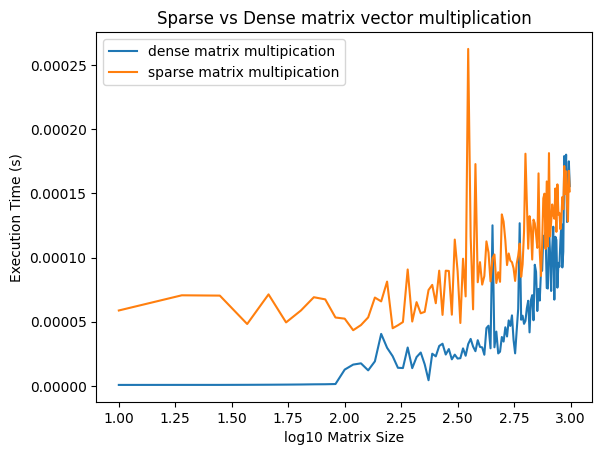

In [69]:
time_comp(sizes = np.arange(10,1000,9))

100%|██████████| 111/111 [28:22<00:00, 15.34s/it]


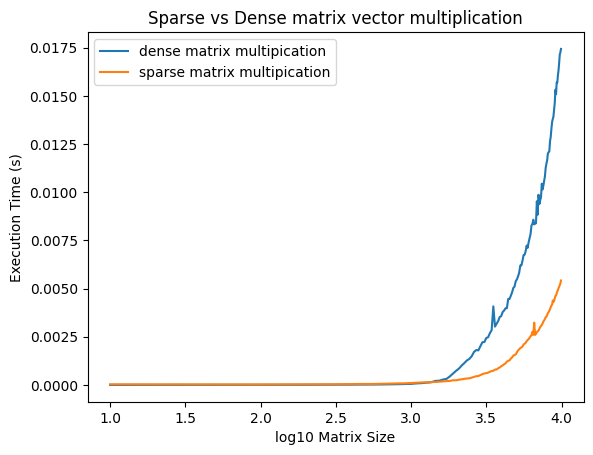

In [56]:
time_comp(sizes = np.arange(10,10000,90))

Now I will test the dense matrix addition vs that of the sparse matrix. It can be seen that the time difference here is less pronounced with the dense matrix addition beating the CSRMatrix sparse matrix addition of the most part due to my implementation being less optimised than the built in numpy one although my addition method only uses one for loop. Due to the element wise computation my manual implementation differs more and more from the dense method as the matrix size gets larger. Matrix sizes larger than 15,000 caused the kernel to crash so can not investigate for even larger matrices. As computational power needed gets exponentially larger with increased matrix size, it is possible that the amount the sparse matrix addition lags behind the dense matrix addition does not scale with the added complexity due to the increased matrix size so there is a possibility of overlap however this hypothesis can not be tested due to computational limitations.

100%|██████████| 111/111 [38:00<00:00, 20.55s/it]


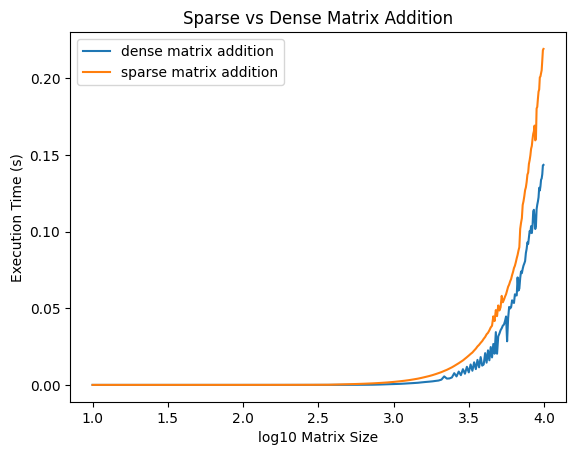

In [57]:
time_comp(settings = {"plot":True,"operation":"+"},sizes = np.arange(10,10000,90))

100%|██████████| 111/111 [38:43<00:00, 20.93s/it]


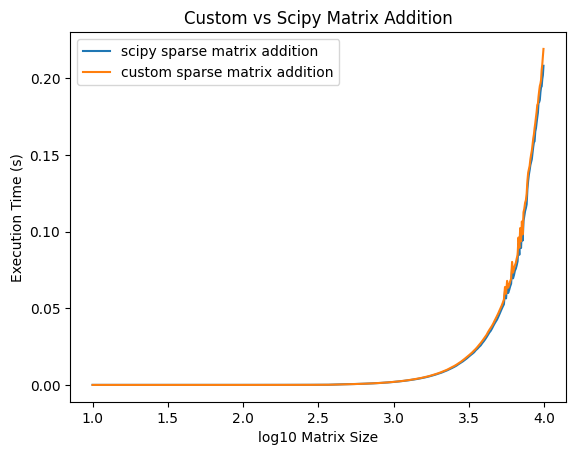

In [58]:
time_comp_scipy(settings = {"plot":True,"operation":"+"},sizes =np.arange(10,10000,90))

100%|██████████| 1110/1110 [7:30:12<00:00, 24.34s/it]      


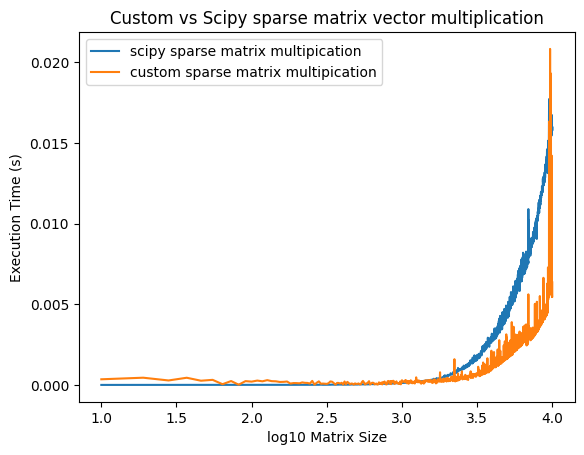

In [70]:
time_comp_scipy(settings = {"plot":True,"operation":"@"},sizes =np.arange(10,10000,9))

Below my custom CSRMatrix implementation will be tested against the scipy csr_matrix() implementation in terms of addition and vector muplication speed. The first cell will cover addition. The second will cover matix vector multiplication. It can be seen that for a density 0.2 sparse matrix, the scipy approach is marginally faster than the custom sparse matrix approach for addition but for matrix vector multiplication the custom sparse matrix was initially slower but then at 10^3 matrix sizes and above began to outperform. The CSR matrix format is optimal for matrix vector multipication due to the row based ordering.

I will now rerun the comparions for a matrix of the standard sparsity of 0.01. It can be seen that the sparse matrix multiplication and addition is much faster than the dense equivalent the more sparse the matrix is which makes sense. This differs from the density 0.2 sparse matrix addition which was slower than the dense equivalent. This indicates that the due to the way the addition is optimised and the fact that it is more computationally intensive as it requires the multiplication of two matrices is only becomes faster than the dense equivalent at low sparsity. It is interesting to see that the custom sparse matrix multiplication is faster than the scipy implementation at higher matrix sizes when the matrix is more sparse although the addition remains tied with the optimised scipy implementation being slightly faster. The scipy implementation is faster initially because it is highly optimised and since the addition method is not parallelised on the cpu but is only JIT compiled it has similar performance. However, the multiplication method is parallelised and JIT compiled so depending on the CPU used to run the code will definitely outperform the scipy implementation as scipy is only in series. Therefore although it is less well optimised the benefits of parallelisation on my pc outweighs this.

Note: It is important to mention that the CSR Matrix storage format is less efficient for extremely sparse and large matrices as the indptr attribute is always one element longer than the number of rows. If the matrix is extremely sparse and a COO matrix format is better as it only would store row and column coordinates of non zero elements. For example a 100 x 100 matrix with 3 values in coo format would only have 3 arrays of storage each 3 elements long however in csr format whilst 2 arrays would be 3 elements long the 3rd indptr array would be 101 elements long.

Due to how long the %timeit magic function takes the graphs below had a limited number of data points.

100%|██████████| 4/4 [00:39<00:00,  9.83s/it]


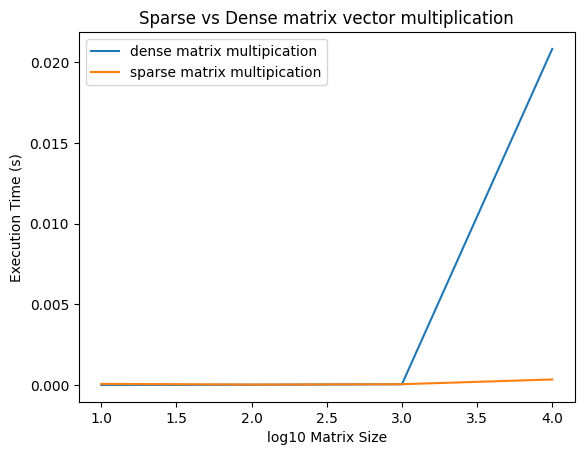

In [79]:
time_comp(density = 0.01,settings = {"plot":True,"operation":"@"})

100%|██████████| 4/4 [01:11<00:00, 17.84s/it]


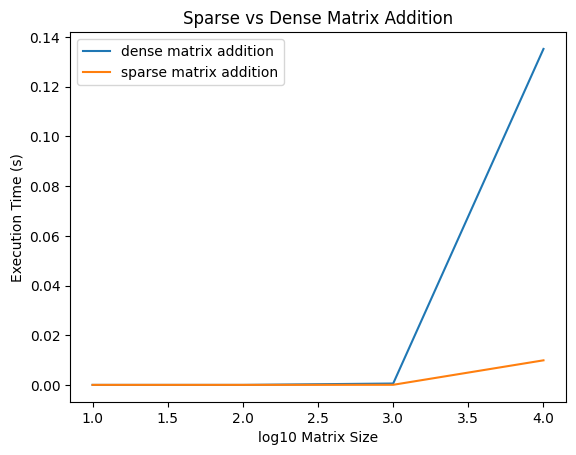

In [80]:
time_comp(density=0.01 ,settings = {"plot":True,"operation":"+"})

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:34<00:00,  8.60s/it]


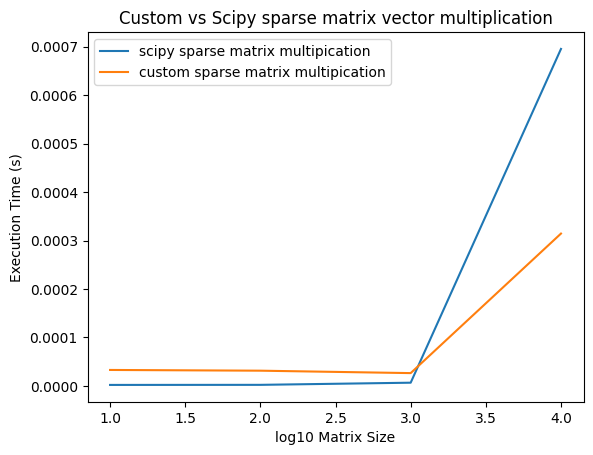

In [81]:
time_comp_scipy(density=0.01,settings = {"plot":True,"operation":"@"})

100%|██████████| 4/4 [01:12<00:00, 18.09s/it]


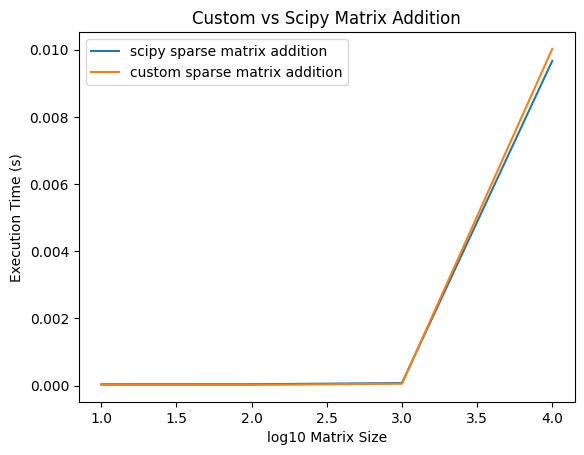

In [82]:
time_comp_scipy(density=0.01,settings = {"plot":True,"operation":"+"})

### Scipy Solvers

Using the Scipy GMRES and CG sparse solvers to solve a custom matrix problem using my custom CSRMatrix() class. I  will plot the solutions against each other for a variety of matrix sizes. The equation that the solvers will be solving can be found below. $A$ represents the matrix which in this case is a sparse CSRMatrix object, $x$ is the solution which is being solved for and the vector generated by np.random.rand is $b$. For the cg solver to work a postive definite matrix is required. A positive definite matrix is defined as a symmetric matrix where every eigenvalue is positive. $x^TAx>0$ where x is a dense vector.

$$
Ax = b
$$

The Conjugate Gradient (CG) and Generalized Minimal Residual (GMRES) solvers are iterative methods for solving linear systems. CG is specialized for symmetric and positive definite matrices and operates by minimizing a quadratic function along conjugate directions, making it efficient and memory-conservative for its target matrix class. In contrast, GMRES can handle more general cases, including non-symmetric matrices, by constructing and minimizing residuals within Krylov subspaces, albeit often at a higher memory cost. While CG is limited to a specific type of matrix but guarantees convergence for them, GMRES is more versatile but may require a restart mechanism to manage memory usage effectively. 

CG:

Begins with an initial guess for the solution x with residual r = b - Ax. Iteratively reduces the value of the quadratic function $f(x) = \frac{1}{2}x^TAx - x^Tb$ (also known as the weighted A norm) and the process is terminated when the residual is sufficiently small. This makes CG extremely efficient for specifically symmetric and positive definite matrices.

GMRES:

This process is more general and works by constructing a sequence of Krylov subspaces: $K_m(A, b) := span{b, Ab, A^2b, ..., A^{m-1}b}$

This follows the arnoldi iteration process to find a vector in the subspace that minimises the 2-norm of the residual $||b-Ax||$. GMRES is more versatile and doesn't require positive definite matrices. The restart mechanism has potential to make convergance more difficult.

In [ ]:
def gen_vec_mat(n):
    seed = np.random.RandomState(42)
    Q = np.linalg.qr(seed.randn(n,n))[0]
    D = np.diag(seed.rand(n))
    coo = coo_matrix(Q.T@D@Q)
    assert np.all(eigs(coo)[0] > 0)
    return CSRMatrix(coo), np.random.rand(n)

In [29]:
mat, vec = gen_vec_mat(100) 

In [30]:
cg_solution = cg(mat,vec)
gmres_solution = gmres(mat,vec)

In [31]:
cg_residual = vec -mat @ cg_solution[0] # finding residual between matrix solution product and vector. Used as an accuracy metric.
gmres_residual = vec - mat @ gmres_solution[0]
print(f"The norm of the residual of the cg sparse matrix solver is {np.linalg.norm(cg_residual)} and that of the gmres sparse matrix solver is {np.linalg.norm(gmres_residual)}.")

The norm of the residual of the cg sparse matrix solver is 5.066000557989345e-05 and that of the gmres sparse matrix solver is 4.0734986885953044e-05.


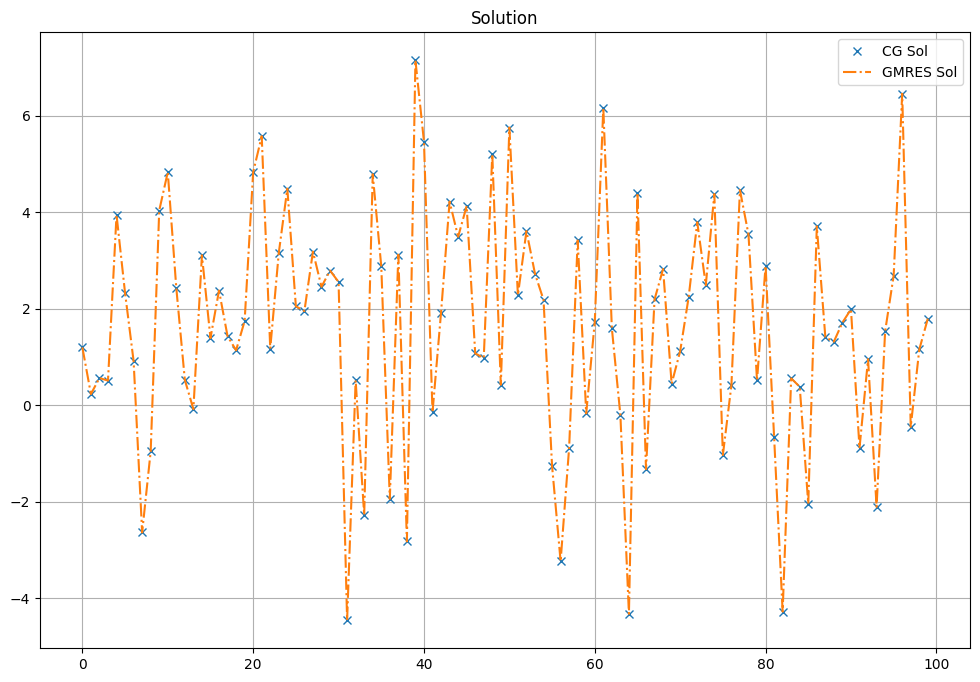

In [32]:
plt.figure(figsize = (12,8))
plt.plot(cg_solution[0],'x',label='CG Sol')
plt.plot(gmres_solution[0],'-.',label='GMRES Sol')
plt.grid(True)
plt.title('Solution')
plt.legend(loc='best')

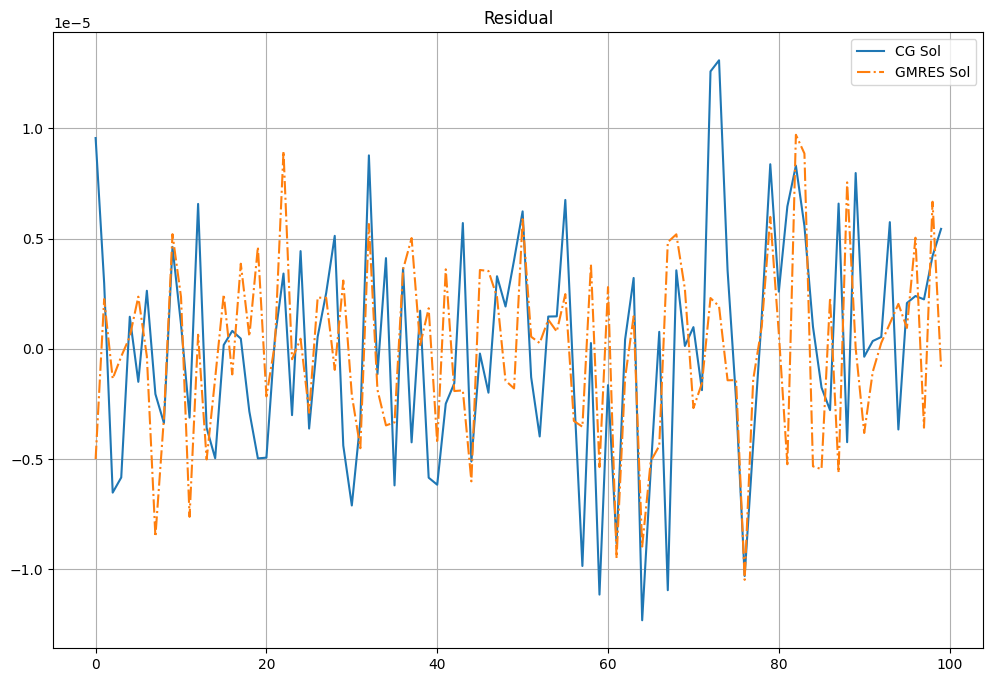

In [33]:
plt.figure(figsize = (12,8))
plt.plot(cg_residual,'-',label='CG Sol')
plt.plot(gmres_residual,'-.',label='GMRES Sol')
plt.grid(True)
plt.title('Residual')
plt.legend(loc='best')

Both solvers have both been tested on a randomised solution that satisfies the positive definite condition. As can be seen the results are very similar and have a similar level of accuracy. The residuals also do not appear to have any specific pattern.

##### Alternate positive definite matrix:

Now I will test these two solvers on a matrix built using the finite difference method to produce an upside down parabola with A representing the discretised version of a second order operator. It is a approximated from the central difference formula below. $$ u''(x_i) \approx \frac{u(x_{i-1}) - 2u(x_i) + u(x_{i+1})}{h^2}$$

In [34]:
#I will use the finite difference method to generate a positive definite matrix
def gen_vec_mat2(n):
    n_squared = n**2
    mid_diag = np.array([2*n_squared for i in range(n)])
    off_diag = np.array([-n_squared for i in range(n-1)])
    coo = diags([mid_diag,off_diag,off_diag],offsets = [0,1,-1],shape = (n,n),format='coo')
    assert np.all(eigs(coo)[0]>0)
    return CSRMatrix(coo), np.random.rand(n)

In [35]:
mat2,vec2 = gen_vec_mat2(100)

In [36]:
cg_solution2 = cg(mat2,vec2)
gmres_solution2 = gmres(mat2,vec2)

In [37]:
cg_residual2 = vec2 -mat2 @ cg_solution2[0] # finding residual between matrix solution product and vector. Used as an accuracy metric.
gmres_residual2 = vec2 - mat2 @ gmres_solution2[0]
print(f"The norm of the residual of the cg sparse matrix solver is {np.linalg.norm(cg_residual2)} and that of the gmres sparse matrix solver is {np.linalg.norm(gmres_residual2)}.")

The norm of the residual of the cg sparse matrix solver is 3.663235912778136e-12 and that of the gmres sparse matrix solver is 5.6777049977606575e-05.


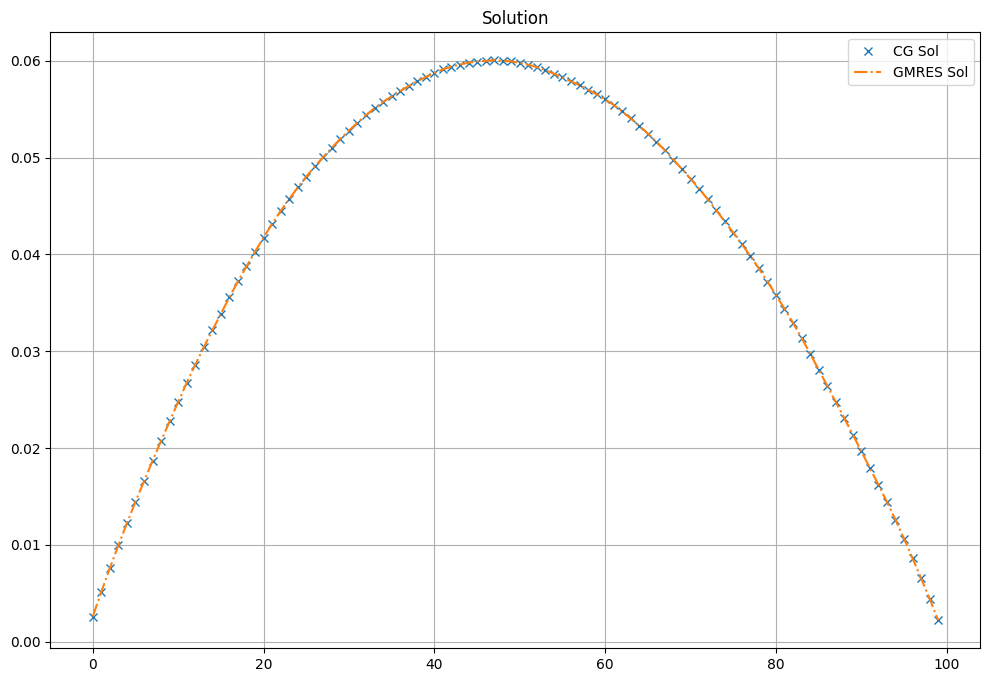

In [38]:
plt.figure(figsize = (12,8))
plt.plot(cg_solution2[0],'x',label='CG Sol')
plt.plot(gmres_solution2[0],'-.',label='GMRES Sol')
plt.grid(True)
plt.title('Solution')
plt.legend(loc='best')

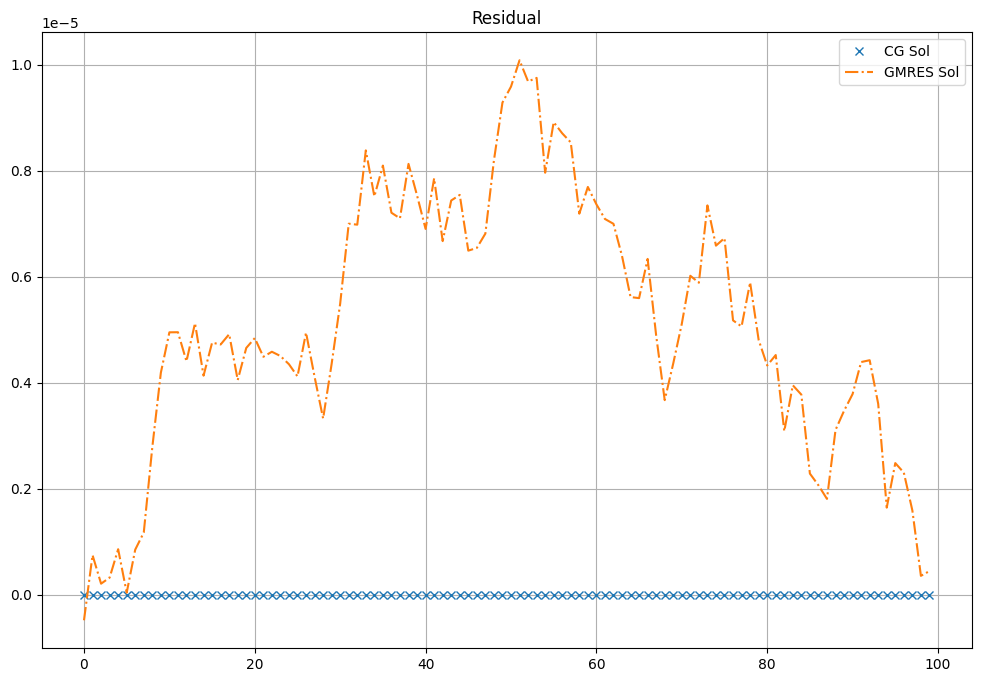

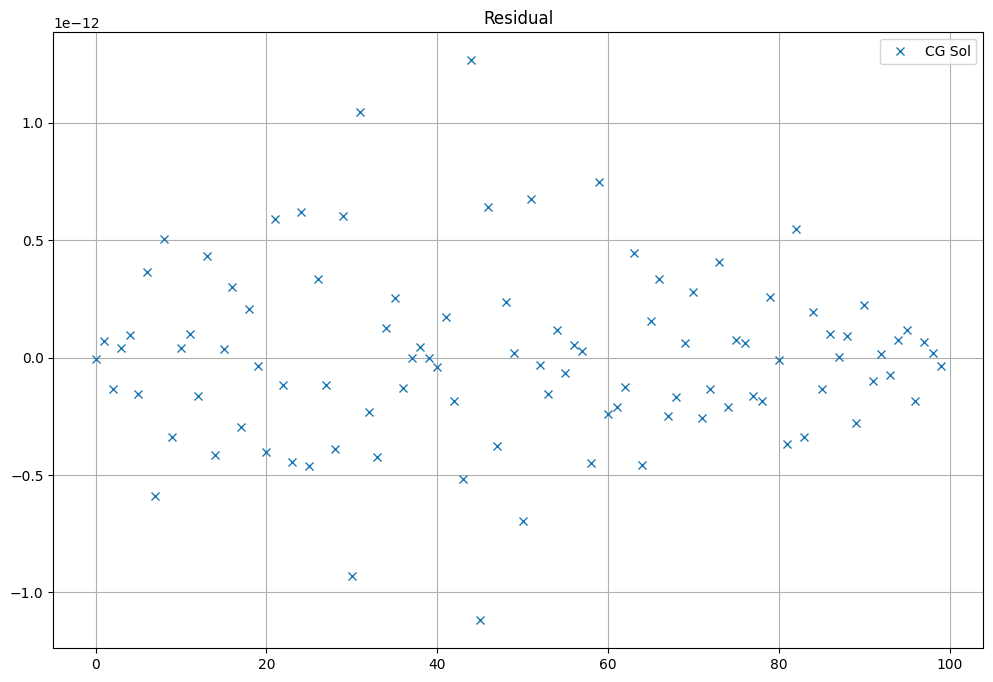

In [39]:
plt.figure(figsize = (12,8))
plt.plot(cg_residual2,'x',label='CG Sol')
plt.plot(gmres_residual2,'-.',label='GMRES Sol')
plt.grid(True)
plt.title('Residual')
plt.legend(loc='best')
plt.figure(figsize = (12,8))
plt.plot(cg_residual2,'x',label='CG Sol')
#plt.plot(gmres_residual2,'-.',label='GMRES Sol')
plt.grid(True)
plt.title('Residual')
plt.legend(loc='best')

It can be seen above that when using a vector and matrix size of 100 the CG solution appears to be much more accurate than the GMRES sol. This is because the conjugate gradient method is much more optimised for this type of problem with a set solution and the restart process in the GMRES solution could potentially increase the time taken for convergance. As well as having a residual 7 orders of magnitude smaller, the residual is also normally distributed around the mean whilst the GMRES residual seems to have the same pattern as the solution itself. The magnitude of the residual seems to scale with the magnitude of the solution. The GMRES residual pattern could be explained by the lack of convergence on a solution caused by the repeats which explains why they are all positive. This indicates that the GMRES solution is proportionally less than the actual solution which is explained by the pattern of the solution being present in the residual itself.

The norm of the residual of the cg sparse matrix solver is 3.923811952298183e-09and that of the gmres sparse matrix solver is 0.00018235598385175163.


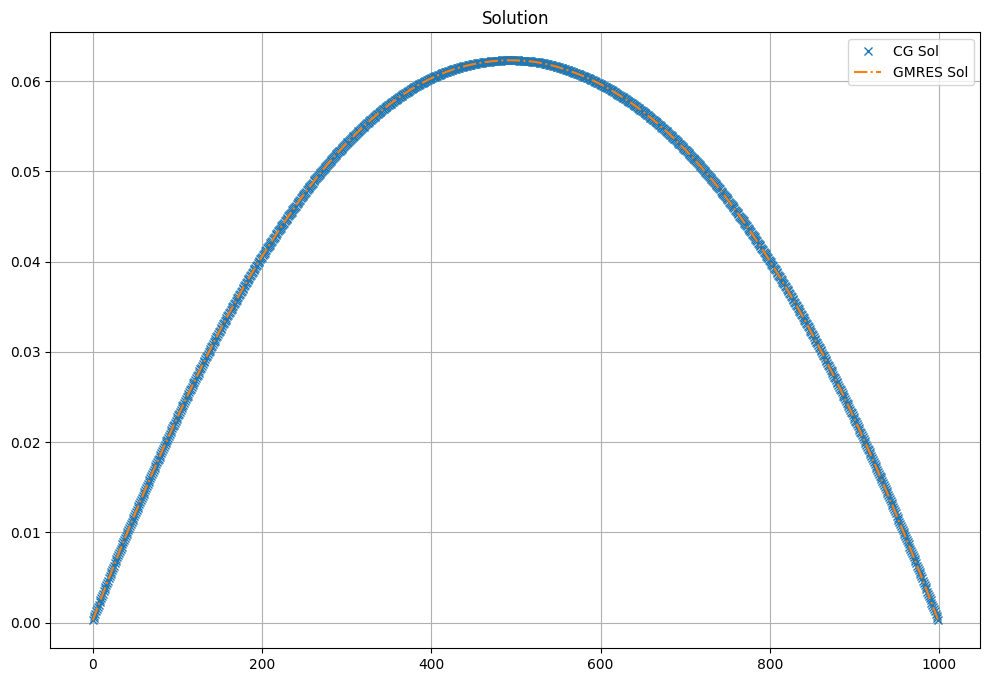

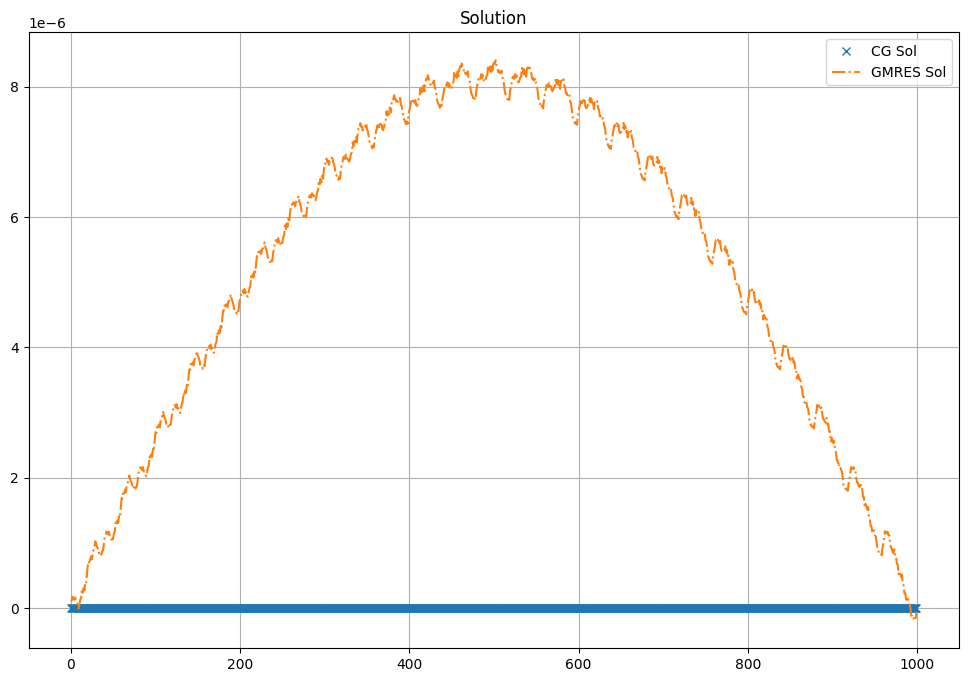

In [86]:
mat3,vec3 = gen_vec_mat2(1000)
cg_solution3 = cg(mat3,vec3)
gmres_solution3 = gmres(mat3,vec3)
cg_residual3 = vec3 -mat3 @ cg_solution3[0] # finding residual between matrix solution product and vector. Used as an accuracy metric.
gmres_residual3 = vec3 - mat3 @ gmres_solution3[0]
print(f"The norm of the residual of the cg sparse matrix solver is {np.linalg.norm(cg_residual3)}"+
      f"and that of the gmres sparse matrix solver is {np.linalg.norm(gmres_residual3)}.")
plt.figure(figsize = (12,8))
plt.plot(cg_solution3[0],'x',label='CG Sol')
plt.plot(gmres_solution3[0],'-.',label='GMRES Sol')
plt.grid(True)
plt.title('Solution')
plt.legend(loc='best')
plt.figure(figsize = (12,8))
plt.plot(cg_residual3,'x',label='CG Sol')
plt.plot(gmres_residual3,'-.',label='GMRES Sol')
plt.grid(True)
plt.title('Residual')
plt.legend(loc='best')
plt.title('Solution')
plt.legend(loc='best')


Here the GMRES solution appears to have an order of magnitude smaller residual caused by the increased accuracy due to the matrix/vector size. The residual of the CG solution appears similar if not slightly larger. The GMRES residual appears to be more defined here. This could be due to the increased overhead caused by the larger dimensions resulting in cnvergence not capturing the full scope of the parabola. This is due to the properties of the Krylov subspace and the convergence nature of the method meaning that the peak is not converged to quicker than the rest of the solution. The GMRES process prioritises capturing the behaviour assosciated with the primary eigenvalues meaning that the residual is the part of the solution which is undetected. The reason why GMRES has this nature unlike CG is because of the residuals being constrained to being orthogonal in the krylov subspace causing sections of the solution to be uncaptured.

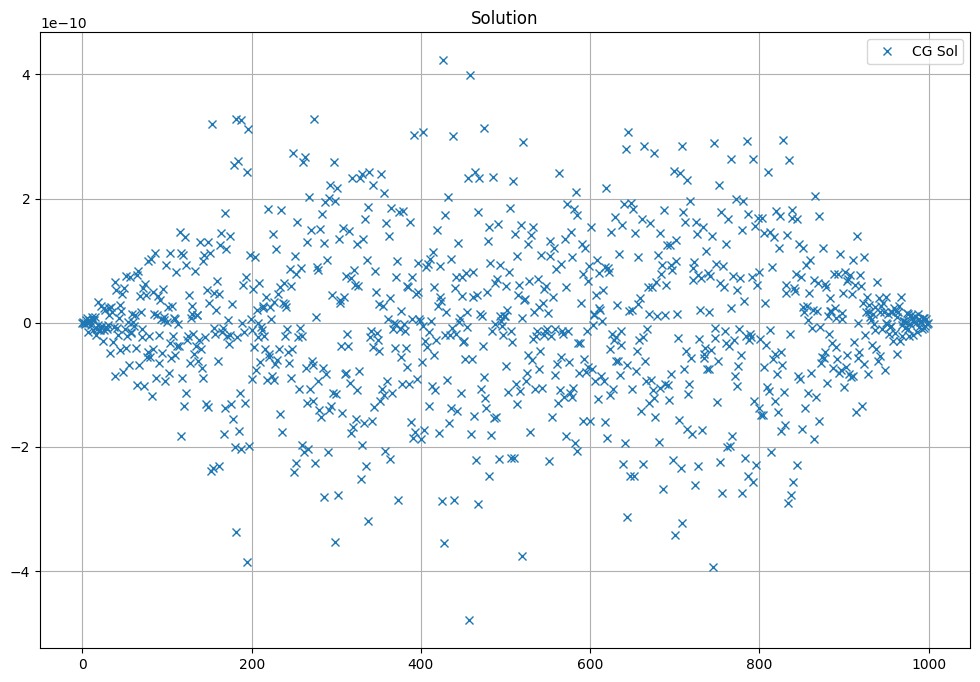

In [87]:
plt.figure(figsize = (12,8))
plt.plot(cg_residual3,'x',label='CG Sol')
#plt.plot(gmres_residual3,'-.',label='GMRES Sol')
plt.grid(True)
plt.title('Residual')
plt.legend(loc='best')
plt.title('Solution')
plt.legend(loc='best')

### Part 2: Implementing a custom matrix

I will now make a class that again inherits from the LinearOperator scipy class. It will implement a custom matrix that for the purposes of this explanation will be labeled A. A is a $2n$ by $2n$ matrix with the following structure.
* The top left $n$ by $n$ block is a diagonal matrix. 
* The top right $n$ by $n$ block is zero.
* The bottom left $n$ by $n$ block is zero.
* The bottom right $n$ by $n$ block is dense with a special structure that will be further explained.

Let $\mathbf{\hat{A}} $ be the bottom right $n$ by $n$ block and can be written in the below equation.
$$
\mathbf{\hat{A}} = \mathbf{TW}
$$

$\textbf{T}$ is an $n$ by 2 matrix and $\textbf{W}$ is a 2 by $n$ matrix.

Below I will implement a class that inherits from scipy LinearOperator that has a matrix vector product using the _matvec method.

In [41]:
class CUST_TW(LinearOperator):
    """
    Class to make custom matrix which is parse apart from a bottom right dense and diagonal top right section.
    """
    def __init__(self,n,topdiag = None,T=None,W = None,A = None,dtype = np.float64):
        self.shape = (2*n,2*n)
        self.dtype = dtype
        if isinstance(topdiag,type(None)):
            self.topdiag = np.random.random(n).astype(dtype = dtype)
        else:
            self.topdiag = topdiag.astype(dtype = dtype)
        if isinstance(A,type(None)):
            if isinstance(T,type(None)):
                T = np.random.random((n,2)).astype(dtype=dtype)
            else:
                if T.shape[1] != 2:
                    raise ValueError("Matrix T does not have 2 columns")
            if isinstance(W,type(None)):
                W = np.random.random((2,n)).astype(dtype = dtype) 
            else:
                if W.shape[0] != 2:
                    raise ValueError("Matrix W does not have 2 rows")
            self.A =  np.dot(T , W)
        else:
            self.A = A.astype(dtype= dtype)
        #self.T = T
        #self.W = W
        pass
    
    def _matvec(self,vector):
        if len(vector) != int(self.shape[0]):
            raise ValueError(f"Matrix-vector product could not be computed for matrix and vector of shapes:",self.shape,vector.shape)
        n = int(self.shape[0]/2)
        product = np.zeros(2*n)
        product[:n] = self.topdiag * vector[:n]
        product[n:] = self.A @ vector[n:]
        return product

    def __add__(self,other):
        """
        Optional addition method.
        """
        topdiag = self.topdiag + other.topdiag
        A = self.A + other.A
        n = int(self.shape[0]//2)
        return CUST_TW(n,topdiag = topdiag,A = A,dtype = self.dtype)

    @staticmethod
    @njit()
    def dense_helper(shape,topdiag,A):
        dense_matrix = np.zeros((shape))
        n = int(shape[0]/2)
        for i in range(n):
            dense_matrix[i,i] = topdiag[i]
            for j in range(n):
                dense_matrix[i + n,j+n] = A[i,j]
        return dense_matrix
    def to_dense(self):
        return self.dense_helper(self.shape,self.topdiag,self.A)

In [42]:
A_ = CUST_TW(1000)
B_ = CUST_TW(1000)

In [49]:
def test_add_TW(n,repeats = 10):
    for i in range(repeats): # testing for multiple repeats.
        cust_mat = CUST_TW(n)
        custmat = CUST_TW(n)
        cust_mat_dense = cust_mat.to_dense()
        custmatdense = custmat.to_dense()
        assert np.allclose(cust_mat_dense + custmatdense, (cust_mat + custmat).to_dense())
    return "The addition method works."
def test_matvec_TW(n,repeats = 10):
    for i in range(repeats):
        custmat = CUST_TW(n)
        vec = np.random.rand(n*2)
        custmatdense = custmat.to_dense()
        assert np.allclose(custmat @ vec, custmatdense@vec)
    return "The multiplication _matvec method works."
def compare_time(sizes = None,min_power = 1, max_power = 4,plot = True):
    if type(sizes) == type(None):
        powers = np.arange(min_power,max_power+1,1)
        sizes = 10**powers
    else:
        powers = np.log10(sizes)
    times1 = []
    times2 = []
    times3 = []
    for i in tqdm(sizes):
        mat = CUST_TW(i)
        mat_dense = mat.to_dense() 
        vector = np.random.rand(2*i) 
        mat_scipy = csr_matrix(mat_dense)
        time1 = %timeit -o -q mat_dense @ vector
        time2 = %timeit -o -q mat @ vector
        time3 = %timeit -o -q mat_scipy @ vector
        title = 'Matrix Vector Multiplication Comparison'
        times1.append(time1.best)
        times2.append(time2.best)
        times3.append(time3.best)
    if plot:
        plt.figure()
        plt.plot(powers,times1,label=f'dense matrix')
        plt.plot(powers,times2,label=f'CUST_TW matrix')
        plt.plot(powers,times3,label='CSR matrix')
        plt.title(title)
        plt.xlabel('log10 Matrix Size')
        plt.ylabel('Execution Time (s)')
        plt.legend(loc='best')
    else:
        return times1,times2, times3

In [50]:
print(test_add_TW(1000))
test_matvec_TW(1000)

The addition method works.


'The multiplication _matvec method works.'

100%|██████████| 111/111 [37:37<00:00, 20.34s/it]


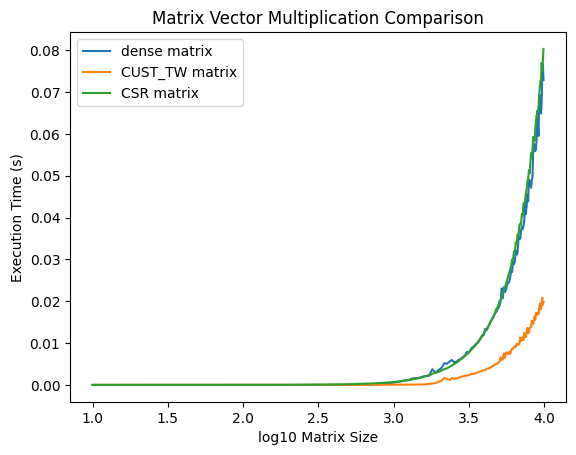

In [51]:
compare_time(sizes = np.arange(10,10000,90))

100%|██████████| 10/10 [02:35<00:00, 15.50s/it]


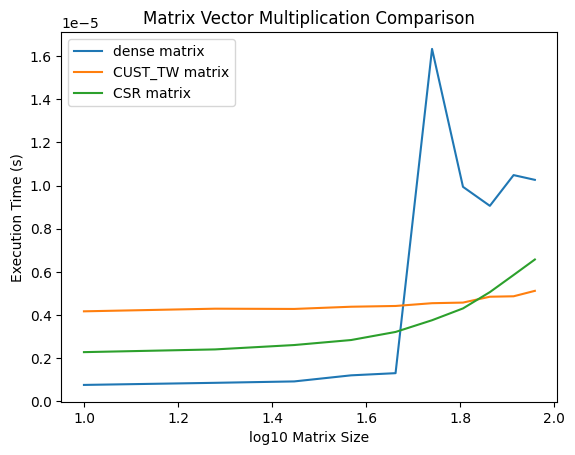

In [ ]:
compare_time(sizes = np.arange(10,100,9))

It should be noted that the scipy implementation is more consistent with more random fluctuations existing for the dense operations. This could be due to dense operations being more dependent on the values themselves whilst the csr matrix format handles only non zero format in a more consistent and regular way.

Here it can be seen that the dense matrix implementation and the scipy CSR matrix implementation of this matrix are both significantly slower than the CUST_TW matrix class I made for this matrix type. This can be explained by the fact that the linear operator format I used precomputes A so the outer product of T and W does not need to be found each time and the fact that the 2n by 2n matrix matrix multiplication with a length 2n vector is split into a length n array being multiplied by a length n vector and an n by n matrix multiplication with a length n vector. As matrix operations become exponentially more computationally expensive, as n becomes larger the computational speed gain from splitting up the operation into the non zero components becomes more prevalent.

Initially for matrix sizes from 10 to 100 the dense matrix initially appears to be faster due to the simpler implementation with the scipy csr matrix outperforming my custom function. However the scipy and numpy optimisations stop being relevant past log10(n) of past 1.6.

I decided to store the entire dense n x n matrix $\tilde{A}$ as although storing T and W independently would take less space when n > 4 as $n^2$ < 4n I decided against this as for every operation that involves A $\tilde{A}$ would need to be computed. Therefore it is much more efficient to pre compute.

In conclusion the CUST_TW matrix format is superior for this type of matrix once log n becomes 1.65 due to the segmented nature of the operations outwieghing the reduced optimisation of my class. The scipy and numpy matrix multiplications speeds are tied due to the matrix being 1/4 dense with all rows and columns of the total matrix having at least one value meaning that the memory occupation and operational cost of both libraries being similar at large values. 